# Recurrent Neural Network

In [1]:
import sys
import os

# Agregar el directorio raiz al PYTHONPATH
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.trainers.utils import build_datasets, save_metrics
from constants.constants_tiktok import TIKTOK_DATASET_SENTENCES

dataset_train, dataset_test, dataset_val = build_datasets(
    TIKTOK_DATASET_SENTENCES,
    test_size=0.3,
    val_size=0.5, # 0.5 de 0.3    
    random_state=42
)
print(dataset_train.shape)
print(dataset_test.shape)
print(dataset_val.shape)

(13727, 2)
(2942, 2)
(2942, 2)


In [17]:
print(dataset_train['polarity'].value_counts())
print(dataset_val['polarity'].value_counts())
print(dataset_test['polarity'].value_counts())

polarity
1    4576
0    4576
2    4575
Name: count, dtype: int64
polarity
2    981
1    981
0    980
Name: count, dtype: int64
polarity
2    981
0    981
1    980
Name: count, dtype: int64


In [3]:

from src.preprocesamiento.nlp_spacy import Tokenizer

tokenizer = Tokenizer()

dataset_train_tokenized = {}
dataset_val_tokenized = {}
dataset_test_tokenized = {}

dataset_train_tokenized['tokens'] = tokenizer.tokenize(dataset_train['text'], True)
dataset_val_tokenized['tokens'] = tokenizer.tokenize(dataset_val['text'], True)
dataset_test_tokenized['tokens'] = tokenizer.tokenize(dataset_test['text'], True)

dataset_train_tokenized['polarity'] = dataset_train['polarity'].to_numpy()
dataset_val_tokenized['polarity'] = dataset_val['polarity'].to_numpy()
dataset_test_tokenized['polarity'] = dataset_test['polarity'].to_numpy()

Modelo cargado: es_core_news_sm


100%|██████████| 2942/2942 [00:02<00:00, 1197.78it/s]


## Entrenar RNN

In [4]:
import numpy as np
from src.trainers.utils import ModelArgs, EarlyStopping 

list_optim = ["adam", "sgd"]
batch_size = 64
list_lr = np.logspace(-4, 1, 10)
print(list_lr)
epochs = 20

patience = None
min_delta = 1e-4

model_args = ModelArgs()
model_args.hidden_size = 30
model_args.num_layers = 2 # 128 bad
model_args.output_size = 3
model_args.dropout = 0.20

[1.00000000e-04 3.59381366e-04 1.29154967e-03 4.64158883e-03
 1.66810054e-02 5.99484250e-02 2.15443469e-01 7.74263683e-01
 2.78255940e+00 1.00000000e+01]


Device: cpu


100%|██████████| 20/20 [02:02<00:00,  6.12s/it, loss=0.813]


RNN adam 0.0001 0.2: 0.650237933378654


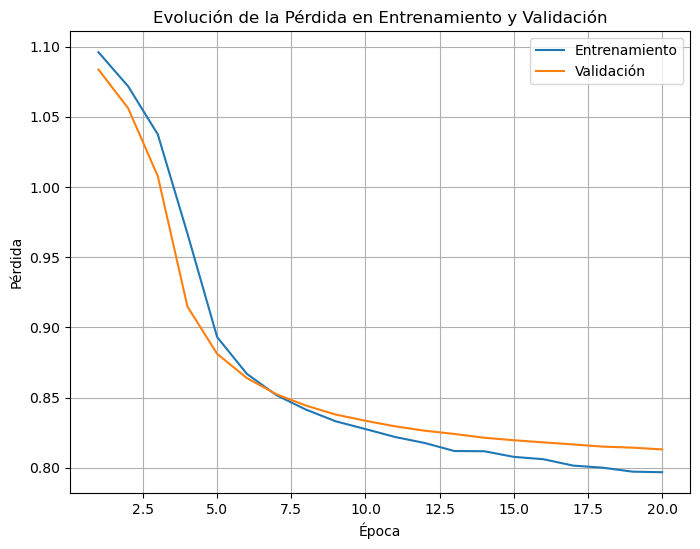

Device: cpu


  5%|▌         | 1/20 [00:07<02:14,  7.09s/it, loss=0.897]


KeyboardInterrupt: 

In [5]:
import os
from src.trainers.train_rnn import train_rnn
from src.trainers.utils import show_loss_val_curves
from constants.constants_tiktok import RNN_LOSS_CURVES_DIR, TIKTOK_RNN_METRICS_PATH, EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

for optim in list_optim:
    for lr in list_lr:
        cont = 0
        model, metrics, train_losses, val_losses = train_rnn(
            dataset_train=dataset_train_tokenized,
            dataset_val=dataset_val_tokenized,
            embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
            model_args=model_args,
            early_stopping = EarlyStopping(patience, min_delta), # reinicio
            batch_size=batch_size,
            lr=lr,
            epochs=epochs,
            optim=optim,
        )
        print(f"RNN {optim} {lr} {model_args.dropout}: {metrics['accuracy']}")
        save_metrics(metrics, TIKTOK_RNN_METRICS_PATH)
        title = f"RNN_{metrics['optim']} {'-'.join(str(lr).split('.'))}"
        path = os.path.join(RNN_LOSS_CURVES_DIR, f"{title}_{str(cont)}.png")
        show_loss_val_curves(train_losses, val_losses, len(train_losses))
        # show_loss_val_curves(train_losses, val_losses, len(train_losses), path)

## Modelo con mayor accuracy

In [6]:
import pandas as pd
from constants.constants_tiktok import RNN_LOSS_CURVES_DIR, TIKTOK_RNN_METRICS_PATH, EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

# Seleccionar los hiperparámetros que generan mayor accuracy
df_metrics = pd.read_csv(TIKTOK_RNN_METRICS_PATH)

best_acc = df_metrics.loc[df_metrics['accuracy'].idxmax()]
print(best_acc)

accuracy           0.650238
recall             0.650244
precision          0.649297
f1_score           0.649189
model                   RNN
optim                  adam
lr                   0.0001
patience                NaN
min_delta            0.0001
rnn_layers                2
hidden_size               2
dropout                 0.2
epochs                   20
batch_size               64
embedding_dim           100
train_time       122.381701
Name: 0, dtype: object


In [ ]:

from src.trainers.utils import ModelArgs, EarlyStopping 

optim = best_acc["optim"]
lr = best_acc["lr"]
batch_size = int(best_acc['batch_size'])
patience = best_acc['patience']
min_delta = best_acc['min_delta']
epochs = int(best_acc['epochs'])
if not np.isnan(patience): # early stopping
    epochs = int(epochs - patience)
early_stopping = EarlyStopping(patience, min_delta)
model_args = ModelArgs()
# model_args.hidden_size = 2
model_args.hidden_size = int(best_acc['hidden_size'])
model_args.num_layers = best_acc['num_layers']
model_args.output_size = 3
model_args.dropout = best_acc['dropout']

c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Device: cpu


100%|██████████| 20/20 [01:00<00:00,  3.03s/it, loss=1.07]


RNN adam 0.0001 0.2: 0.4245411284840245
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\rnn_model.pth

RNN
Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.60      0.46      0.52      1278
           1       0.32      0.36      0.34       854
           2       0.38      0.46      0.41       810

    accuracy                           0.43      2942
   macro avg       0.43      0.43      0.42      2942
weighted avg       0.46      0.43      0.44      2942

Matriz de confusión


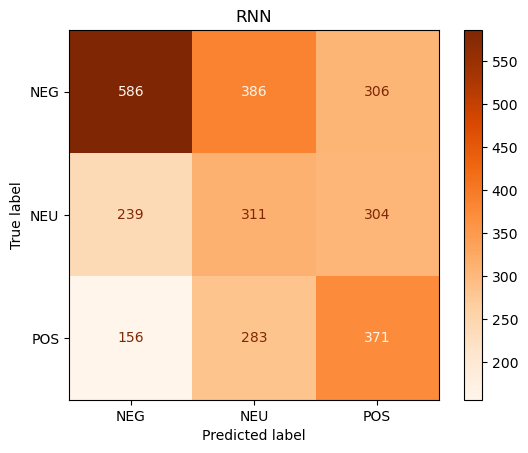

{'accuracy': 0.4309993201903467, 'recall': 0.43096070232374295, 'precision': 0.42690742037056717, 'f1_score': 0.42408557508172856}


In [10]:
from constants.constants_tiktok import RNN_MODEL_PATH
from src.trainers.utils import save_model_torch
from src.trainers.trainer_rnn import evaluate_model
from src.trainers.train_rnn import train_rnn

model, metrics, train_losses, val_losses = train_rnn(
    dataset_train=dataset_train_tokenized,
    dataset_val=dataset_val_tokenized,
    embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
    model_args=model_args,
    early_stopping = early_stopping, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    optim=optim,
)
print(f"RNN {optim} {lr} {model_args.dropout}: {metrics['accuracy']}")

save_model_torch(model.get_model(), RNN_MODEL_PATH)

metrics = evaluate_model(
    model,
    dataset_test_tokenized,
    "RNN",
    EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
    batch_size,
)
print(metrics)

In [ ]:
from src.trainers.train_rnn import RNNModel
from constants.constants_tiktok import RNN_MODEL_PATH
from src.trainers.utils import load_model_torch
from src.trainers.train_rnn import SentimentAnalysis

from src.preprocesamiento.nlp_spacy import Tokenizer

tokenizer = Tokenizer()

model = RNNModel(model_args)
model = load_model_torch(model, RNN_MODEL_PATH)
cls = SentimentAnalysis(model, tokenizer, EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,"cpu")

Modelo cargado: es_core_news_sm
Cargando modelo: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\rnn_model.pth


c:\Users\Diego\anaconda3\envs\tensorflow_pytorch\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
c:\Users\Diego\Desktop\sentiment_analysis\src\trainers\utils.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

In [12]:
from src.preprocesamiento.clean import clean_text
from src.preprocesamiento.nlp_spacy import preprocesamiento

textos_test = ["Hola! cómo estás???😀","el dia de hoy estoy feliz y contento", "estoy muy triste", "Me encuentro estudiando para un exámen", "A veces me encuentro triste, pero la mayoria del tiempo estoy muy feliz"]
textos_test = list(map(lambda x: clean_text(x), textos_test))
textos_test = preprocesamiento(textos_test)
for texto in textos_test:
    print(cls.predict(texto))

Modelo cargado: es_core_news_sm


100%|██████████| 5/5 [00:00<00:00, 1245.04it/s]
5it [00:00, 353.61it/s]

Aplicando stemming...
Total de documentos preprocesados: 5
[('NEU', 0.37163621187210083), ('POS', 0.36557576060295105), ('NEG', 0.2627880275249481)]
[('NEG', 0.3531063497066498), ('NEU', 0.33019542694091797), ('POS', 0.31669819355010986)]
[('NEG', 0.38836121559143066), ('NEU', 0.3106423020362854), ('POS', 0.30099645256996155)]
[('POS', 0.41537928581237793), ('NEU', 0.3587677478790283), ('NEG', 0.22585290670394897)]
[('POS', 0.41537928581237793), ('NEU', 0.3587677478790283), ('NEG', 0.22585290670394897)]
